# Train P-Net
- 162,770 train images, 19,867 eval images
- EPOCH = 40
- LR = 0.001
- batch size = 32
- num of worker = 8
- loss configuration: 1.0 for label, 0.5 for offset

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.functional as tf
from PIL import Image
import os.path as osp
import numpy as np
from numpy.random import uniform
import PIL
from PIL import Image, ImageDraw
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import math
import random
import argparse
import os
import copy
import json
import warnings
warnings.filterwarnings("ignore")

## PnetDataset: gives both boxes and landmarks 

In [3]:
def IoU(box, face):

    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (face[2] - face[0] + 1) * (face[3] - face[1] + 1)

    xx1 = np.maximum(box[0], face[0])
    yy1 = np.maximum(box[1], face[1])
    xx2 = np.minimum(box[2], face[2])
    yy2 = np.minimum(box[3], face[3])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr

In [5]:
root =  '../input/celeba-original-wild-images/'

class PnetDataset(data.Dataset):
    def __init__(self, phase, num_images, ratio=(1, 1, 1, 1)):
        
        self.idx = {'train': (0,162769), 'val': (162770,182636), 'test': (182637,202598)}.get(phase)  # double inclusive
        self.length = num_images
        
        self.boxes_frame = pd.read_csv('../input/celeba-original-wild-images/list_bbox_celeba.csv')
        self.landmarks_frame = pd.read_csv('../input/landmark/list_landmarks_celeba.csv')
        
        ratio_sum = float(sum(ratio))
        self.ratio = [i / ratio_sum for i in ratio]
    
    
    def get_crop_img_label_offset_ldmk(self, img, face, ldmk):
        def get_crop_img(img_np, crop_box):
            crop_box = [int(i) for i in crop_box]
            crop_img_np = img_np[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :]
            crop_img = Image.fromarray(crop_img_np, mode='RGB')
            crop_img = crop_img.resize((12,12), resample=PIL.Image.BILINEAR)
            return crop_img


        def cal_offset(face, box):
            if box is None:
                return []
            offset = [
                (face[0] - box[0]) / float(box[2] - box[0]),
                (face[1] - box[1]) / float(box[3] - box[1]),
                (face[2] - box[2]) / float(box[2] - box[0]),
                (face[3] - box[3]) / float(box[3] - box[1]),
            ]
            return offset

        
        def cal_landmark_offset(box, ldmk):
            minx, miny = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            ldmk_offset = [(ldmk[i] - [minx, miny][i % 2]) / float([w, h][i % 2]) for i in range(len(ldmk))]
            return ldmk_offset
        
        face[2] += face[0]
        face[3] += face[1]
        img_np = np.array(img)
        width, height = img.size
        
        label = np.random.choice(['n', 'np', 'pf', 'p'], p=self.ratio)
        iou_th = {'n': (0, 0.3), 'np': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}.get(label)
        sigma = {'n': 1, 'np': 0.3, 'pf': 0.1, 'p': 0.02}.get(label)
        

        face_max_size = max(face[2] - face[0], face[3] - face[1])
        
        max_size = min(width, height)
        
        crop_img = None
        crop_box = None
        
        for i in range(10):
            size = (uniform(-1.0, 1.0) * sigma + 1) * face_max_size
            size = min(max(12, size), max_size)
            x1, y1 = face[0], face[1]
            crop_x1, crop_y1 = (uniform(-1.0, 1.0) * sigma + 1) * x1, (uniform(-1.0, 1.0) * sigma + 1) * y1

            crop_x1, crop_y1 = min(max(0, crop_x1), width - size), min(max(0, crop_y1), height - size)
            crop_box = np.array([int(crop_x1), int(crop_y1), int(crop_x1 + size), int(crop_y1 + size)])
            iou = IoU(crop_box, face)

            if iou < iou_th[0] or iou > iou_th[1]:
                continue
            else:
                crop_img = get_crop_img(img_np, crop_box)
                break
                
        return crop_img, label, cal_offset(face, crop_box), cal_landmark_offset(crop_box, ldmk), crop_box, face


    def __getitem__(self, index):
        
        n = random.randint(self.idx[0],self.idx[1])
        
        name = self.landmarks_frame.iloc[n, 0]

        part = int(name[:2]) if name[2:6]=='0000' else int(name[:2])+1
        full_path = root+'Part '+str(part)+'/Part '+str(part)+'/'+name
        try:
            img = Image.open(full_path)
        except:
            print('invalid image')
            return self.__getitem__(0)

        img = Image.open(full_path)
    
        ldmk = self.landmarks_frame.iloc[n, 1:]
        ldmk = np.asarray(ldmk, dtype=np.float32)
        
        face = self.boxes_frame.iloc[n, 1:]
        face = np.asarray(face,dtype=np.float32)
        
        crop_img, label, offset, ldmk, crop_box, face = self.get_crop_img_label_offset_ldmk(img, face, ldmk)
        
        if crop_img is None: return self.__getitem__(0)
        
        img_tensor = transforms.ToTensor()(crop_img)
        label = torch.FloatTensor([1.0 if label in ['p', 'pf'] else 0.0])
        offset = torch.FloatTensor(offset)
        landmark = torch.FloatTensor(ldmk)
        
        return (img_tensor, label, offset, label, landmark)
    
    
    def __len__(self):
        return self.length

## P-Net and customized loss function

In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)
        

class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(10, 16, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.PReLU()
        )
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1,)
        self.apply(weights_init)

        
    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        return det, box, landmark

In [9]:
class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):

        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss()
        self.loss_box = nn.MSELoss()
        self.loss_landmark = nn.MSELoss()


    def cls_loss(self, gt_label, pred_label):
        
        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        mask = torch.ge(gt_label, 0)        
        valid_gt_label = gt_label[mask]
        valid_pred_label = pred_label[mask]
        
        return self.loss_cls(valid_pred_label, valid_gt_label) * self.cls_factor
    
    
    def box_loss(self, gt_label, gt_offset, pred_offset):

        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)
        mask = torch.eq(gt_label, 1)
        
        valid_gt_offset = gt_offset[mask, :]
        valid_pred_offset = pred_offset[mask, :]
        valid_sample_num = valid_gt_offset.shape[0]
        
        if 0 == valid_sample_num:
            return torch.tensor([0.0])
        else:
            return self.loss_box(valid_pred_offset, valid_gt_offset) * self.box_factor

        
        
    def landmark_loss(self, landmark_flag, gt_landmark, pred_landmark):
        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(landmark_flag)
        mask = torch.eq(gt_label, 1)
        valid_gt_landmark = gt_landmark[mask, :]
        valid_pred_landmark = pred_landmark[mask, :]
        valid_sample_num = valid_gt_landmark.shape[0]
        if 0 == valid_sample_num:
            return torch.tensor([0.0])
        else:
            return self.loss_landmark(valid_pred_landmark, valid_gt_landmark) * self.land_factor

        
    def total_loss(self, gt_label, pred_label, gt_offset, pred_offset, landmark_flag, gt_landmark, pred_landmark):
        return self.cls_loss(gt_label, pred_label) \
               + self.box_loss(gt_label, gt_offset, pred_offset) \
               + self.landmark_loss(landmark_flag, gt_landmark, pred_landmark)

In [10]:
def visualize_accuracy(statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='total loss',title='total loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='landmark loss',title='landmark loss at the xth epoch');
        ax2.legend();
    fig.show()
    fig.savefig(fig_name)

In [11]:
def train_Pnet(model, criterion, optimizer, loss_config, scheduler=None):
    
    train_begin = time.time()
    min_loss = 100.0
    best_model_wts = copy.deepcopy(model.state_dict())
    statistics = {'train':([],[]), 'eval':([],[])} # ([total loss],[class loss])
    

    for epoch in range(EPOCH):
        print('Epoch {}/{}'.format(epoch, EPOCH - 1))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        running_lm = 0.0
        
        for (img_tensor, label, offset, landmark_flag, landmark) in P_trainLoader:
            
            
            wrap = (img_tensor, label, offset, landmark)
            (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
            det, box, ldmk = model(img_tensor)

            optimizer.zero_grad()
            all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                       landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
            lm_loss = criterion.landmark_loss(landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)

            all_loss.backward()
            optimizer.step()
            
            running_loss += all_loss.item() * img_tensor.size(0)
            running_lm += lm_loss.item() * img_tensor.size(0)
        epoch_loss = running_loss / P_trainSize
        epoch_lm_loss = running_lm / P_trainSize
        statistics['train'][0].append(epoch_loss)
        statistics['train'][1].append(epoch_lm_loss)
        if scheduler is not None:
            scheduler.step(epoch_loss)
            lr = optimizer.param_groups[0]['lr']
        print('Train Loss: {:.4f}  lm loss: {:.4f}  lr: {:.7f}'.format(epoch_loss, epoch_lm_loss, lr))
        
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_lm = 0.0

            for (img_tensor, label, offset, landmark_flag, landmark) in P_evalLoader:

                wrap = (img_tensor, label, offset, landmark)
                (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
                det, box, ldmk = model(img_tensor)

                all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                           landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
                lm_loss = criterion.landmark_loss(landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
                
                running_loss += all_loss.item() * img_tensor.size(0)
                running_lm += lm_loss.item() * img_tensor.size(0)
                
            epoch_loss = running_loss / P_evalSize
            epoch_lm_loss = running_lm / P_evalSize
            statistics['eval'][0].append(epoch_loss)
            statistics['eval'][1].append(epoch_lm_loss)
            print('Eval Loss: {:.4f}  lm loss: {:.4f}'.format(epoch_loss, epoch_lm_loss))
        print()
        
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    train_length = time.time() - train_begin
    print('Training complete in {:.0f}m {:.0f}s'.format(train_length // 60, train_length % 60))
    print('Min train loss: {:4f}'.format(min_loss))
    model.load_state_dict(best_model_wts)
    
    return model, statistics

In [12]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


LR = 0.001
EPOCH = 40
BATCH_SIZE = 32
NUM_WORKS = 8
Pnet_loss_config = [1.0, 0.5, 0.5]


P_trainset = PnetDataset('train', 5000)
P_trainLoader = DataLoader(P_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

P_evalset = PnetDataset('val', 1000)
P_evalLoader = DataLoader(P_evalset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

P_trainSize = len(P_trainset)
P_evalSize = len(P_evalset)
print(P_trainSize)
print(P_evalSize)


model = P_Net().cuda()
model.load_state_dict(torch.load('/kaggle/input/trainedmtcnn/PNet3.pth'))
for param in model.conv4_3.parameters():
    print(param.requires_grad)
    
optimizer = opt.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = LossFn(cls_factor=Pnet_loss_config[0], box_factor=Pnet_loss_config[1], landmark_factor=Pnet_loss_config[2])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
        verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)

5000
1000
True
True


In [13]:
model, statistics = train_Pnet(model, criterion, optimizer, Pnet_loss_config, scheduler)

Epoch 0/39
----------
Train Loss: 0.2004  lm loss: 0.0414  lr: 0.0010000
Eval Loss: 0.1966  lm loss: 0.0172

Epoch 1/39
----------
Train Loss: 0.1463  lm loss: 0.0130  lr: 0.0010000
Eval Loss: 0.1339  lm loss: 0.0095

Epoch 2/39
----------
Train Loss: 0.1371  lm loss: 0.0092  lr: 0.0010000
Eval Loss: 0.1270  lm loss: 0.0074

Epoch 3/39
----------
Train Loss: 0.1252  lm loss: 0.0071  lr: 0.0010000
Eval Loss: 0.1448  lm loss: 0.0070

Epoch 4/39
----------
Train Loss: 0.1158  lm loss: 0.0068  lr: 0.0010000
Eval Loss: 0.0980  lm loss: 0.0052

Epoch 5/39
----------
Train Loss: 0.1141  lm loss: 0.0050  lr: 0.0010000
Eval Loss: 0.1095  lm loss: 0.0047

Epoch 6/39
----------
Train Loss: 0.1172  lm loss: 0.0045  lr: 0.0010000
Eval Loss: 0.0873  lm loss: 0.0039

Epoch 7/39
----------
Train Loss: 0.1133  lm loss: 0.0042  lr: 0.0010000
Eval Loss: 0.0912  lm loss: 0.0038

Epoch 8/39
----------
Train Loss: 0.1141  lm loss: 0.0106  lr: 0.0010000
Eval Loss: 0.1307  lm loss: 0.0044

Epoch 9/39
--------

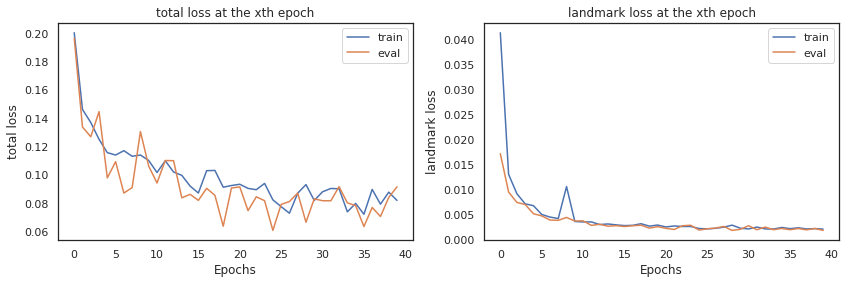

In [14]:
name = 'PNl_bd_1'
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')
json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(statistics, name)